Возьмем датасет с рейтингами аниме и попробуем посоветовать пользователям сайта, что же им еще можно посмотреть.

данные можно скачать по ссылке: https://www.kaggle.com/CooperUnion/anime-recommendations-database

## Обработка данных

In [5]:
import pandas as pd
import numpy as np
import scipy.sparse as scp

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from warnings import filterwarnings
filterwarnings('ignore')

Загрузим датасет с аниме, их названием, жанром, типом, кол-вом эпизодов, рэйтингом и кол-вом смотрящих/посмотревших

In [6]:
anime = pd.read_csv('anime-recommendations-database/anime.csv')

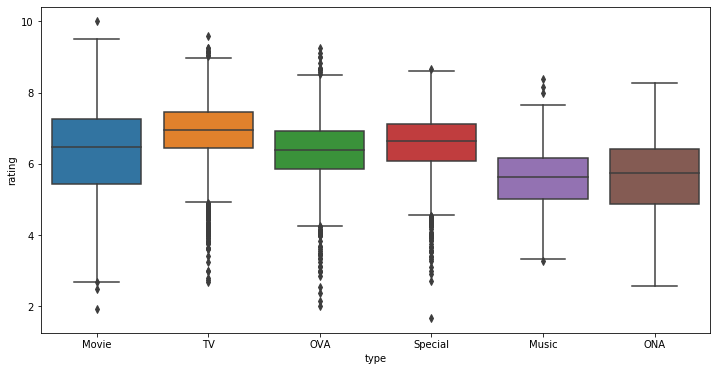

In [7]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=anime,x='type',y='rating')

Рассмотрим только те аниме, которые входят в категорию TV

In [8]:
anime = anime.loc[anime.type == 'TV']
anime.head()

,anime_id,name,genre,type,episodes,rating,members
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
5,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10,9.15,93351


Всего в датасете 3787 уникальных аниме

In [9]:
len(anime.name.unique())

3787

In [10]:
anime.episodes = pd.to_numeric(anime.episodes.replace('Unknown', ''), downcast='integer')

Посмотрим на статистику для числовых показателей аниме: кол-во эпизодов, рэйтинг, кол-во смотрящих

In [11]:
anime[['episodes', 'rating', 'members']].describe()

,episodes,rating,members
count,3578.000000,3671.000000,3.787000e+03
mean,35.915595,6.902299,4.268366e+04
std,80.640355,0.863526,8.912101e+04
min,2.000000,2.670000,1.200000e+01
25%,12.000000,6.440000,4.830000e+02
50%,24.000000,6.940000,5.947000e+03
75%,39.000000,7.460000,4.424600e+04
max,1818.000000,9.600000,1.013917e+06


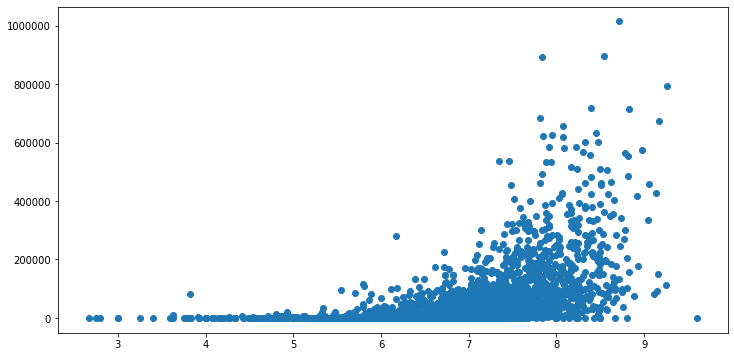

In [12]:
plt.figure(figsize=(12, 6))
plt.scatter(anime.rating, anime.members)

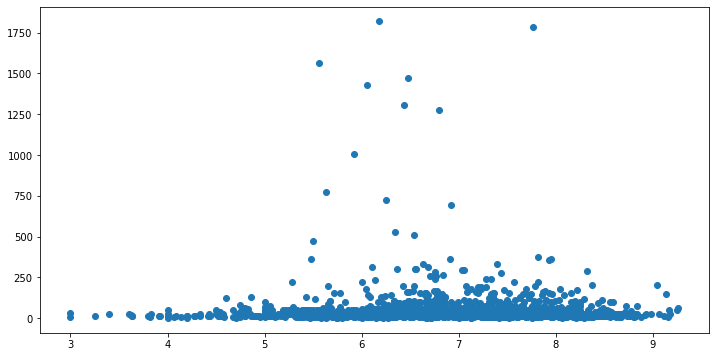

In [13]:
plt.figure(figsize=(12, 6))
plt.scatter(anime.rating, anime.episodes)

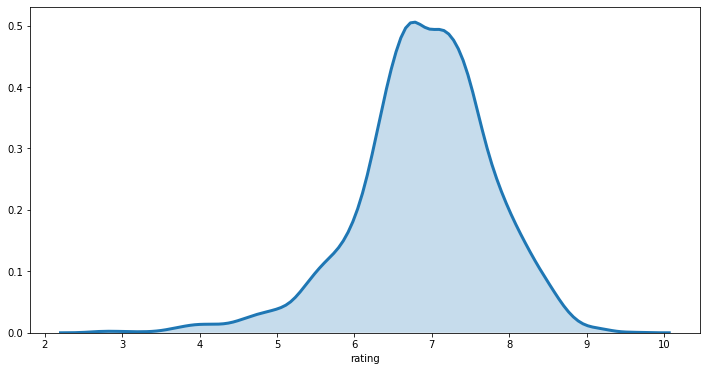

In [14]:
plt.figure(figsize=(12, 6))
sns.distplot(anime.rating, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3}, 
             label = '')

(3.0, 0.0)

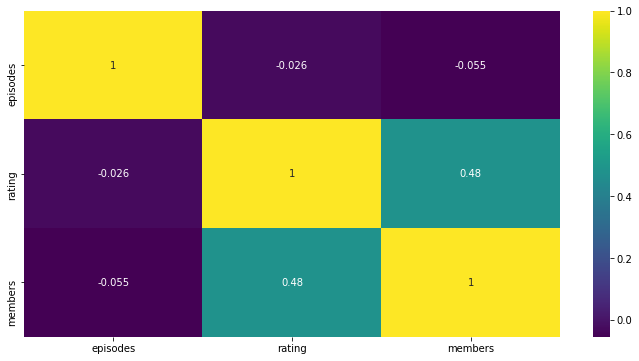

In [15]:
plt.figure(figsize=(12, 6))
ax = sns.heatmap(anime[['episodes', 'rating', 'members']].corr(), annot=True, cmap='viridis')
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)

Так же загрузим датасет с рейтигами, который пользователи ставили определенным аниме

In [16]:
rating = pd.read_csv('anime-recommendations-database/rating.csv')
rating.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


Как видим, оба датасета имеют поле `anime_id`. Можем по этому полю соединить обе таблицы. Получим таблицу `merged`, в которой хранится, какой пользователь поставил какую оценку конкретному аниме.

In [17]:
merged = rating.merge(anime, left_on='anime_id', right_on='anime_id', suffixes=['_user', ''])
merged.head()

,user_id,anime_id,rating_user,name,genre,type,episodes,rating,members
0,1,20,-1,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220.0,7.81,683297
1,3,20,8,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220.0,7.81,683297
2,5,20,6,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220.0,7.81,683297
3,6,20,-1,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220.0,7.81,683297
4,10,20,-1,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220.0,7.81,683297


Нам не нужно знать все о получившийся таблице. Главное знать id пользователя, название аниме и саму оценку. Оставим только нужные нам поля.

In [18]:
merged = merged[['user_id', 'name', 'rating_user']]
merged.head()

,user_id,name,rating_user
0,1,Naruto,-1
1,3,Naruto,8
2,5,Naruto,6
3,6,Naruto,-1
4,10,Naruto,-1


Изменим навзание поля `rating_user` на более удобное для понимания: `user_rating`

In [19]:
merged.rename(columns={'rating_user': 'user_rating'}, inplace=True)
merged.head()

,user_id,name,user_rating
0,1,Naruto,-1
1,3,Naruto,8
2,5,Naruto,6
3,6,Naruto,-1
4,10,Naruto,-1


Рейтинг `-1` значит, что пользователь посмотел аниме, но не поставил ему оценку. Так как нас интересуют только рейтинги, можно выкинуть все `-1`

In [20]:
merged = merged.loc[merged.user_rating != -1]
merged.head()

,user_id,name,user_rating
1,3,Naruto,8
2,5,Naruto,6
5,21,Naruto,8
6,28,Naruto,9
7,34,Naruto,9


Выкинем часть датасета, чтобы избежать проблем с вычислениями.

In [21]:
merged = merged.loc[merged.user_id <= 10000]
merged.head()

,user_id,name,user_rating
1,3,Naruto,8
2,5,Naruto,6
5,21,Naruto,8
6,28,Naruto,9
7,34,Naruto,9


In [22]:
merged.groupby(merged.user_rating).count()

,user_id,name
user_rating,,
1,1086,1086
2,1875,1875
3,3308,3308
4,8591,8591
5,22910,22910
6,54036,54036
7,123378,123378
8,155788,155788
9,122404,122404


<BarContainer object of 10 artists>

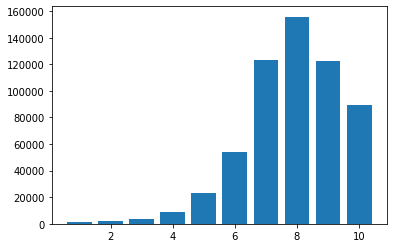

In [23]:
a = pd.DataFrame(merged.groupby(merged.user_rating).count())
plt.bar(a.index, a.user_id)

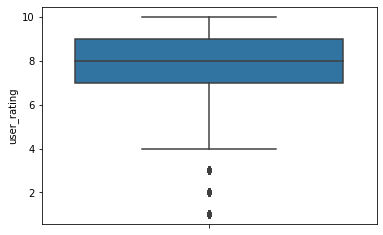

In [24]:
sns.boxplot(y=merged.user_rating)

Теперь разобьем данные на train и test части

In [25]:
from sklearn.model_selection import train_test_split

random_state = 314159

In [26]:
train_data, dev_data = train_test_split(merged, test_size=0.1, random_state=random_state)
train_data.sort_index(inplace=True)
dev_data.sort_index(inplace=True)
train_data.shape, dev_data.shape

((524152, 3), (58240, 3))

Train часть датасета

In [27]:
train_data.head()

,user_id,name,user_rating
1,3,Naruto,8
2,5,Naruto,6
5,21,Naruto,8
6,28,Naruto,9
7,34,Naruto,9


Test часть датасета

In [28]:
dev_data.head()

,user_id,name,user_rating
33,118,Naruto,7
34,124,Naruto,7
35,125,Naruto,4
39,132,Naruto,9
43,148,Naruto,8


In [29]:
if len(merged.user_id.unique()) == merged.user_id.max():
    print('Количество уникальных пользователей совпадает с максимальным id пользователя')
else:
    print('Количество уникальных пользователей НЕ совпадает с максимальным id пользователя')

Количество уникальных пользователей НЕ совпадает с максимальным id пользователя


In [30]:
merged.user_id.unique()

array([   3,    5,   21, ..., 2238, 5252, 3530])

Количество уникальных пользователей не совпадает с максимальным id пользователя, а это значит, что id пользователей сдвинуты. Так, например, отсутствуют пользователи, с `id` 0, 1, 2  и 4.

В дальнейшем нам надо будет работать с матрицей рейтингов, где 0-ая строка соответствует пользователю с `id` 3, 1-ая строка - пользователю с `id` 5 и так далее. Поэтому для удобства создадим словарь, который переводит настоящий id пользователя в удобный нам. Сразу же сделаем словарь, который делает обратное преобразование.

In [31]:
user_to_idx = {user_id : idx for idx, user_id in enumerate(merged.user_id.unique())}
idx_to_user = {i: user for user, i in user_to_idx.items()}

Первый словать перевел пользователя с id 5 в пользователя с id 1.

In [32]:
user_to_idx[5]

1

Обратное преобразование так же работает

In [33]:
idx_to_user[1]

5

Так же необходимо сопоставить именам аниме индексацию 

In [34]:
anime_to_idx = {anime_name : idx for idx, anime_name in enumerate(merged.name.unique())}
idx_to_anime = {i: anime_name for anime_name, i in anime_to_idx.items()}

0-ому столбцу соответсвует Naruto :)

In [35]:
idx_to_anime[0]

'Naruto'

Преобразуем train часть датасета с помощью преобразований, описанных выше.

In [36]:
data = train_data.copy()
data['user_id'] = data['user_id'].apply(lambda x: user_to_idx[x])
data['name'] = data['name'].apply(lambda x: anime_to_idx[x])
data.head()

,user_id,name,user_rating
1,0,0,8
2,1,0,6
5,2,0,8
6,3,0,9
7,4,0,9


## Создание матрицы рейтингов

Составим саму матрицу рейтингов. Если мы будем хранить все значения, то есть не только сами оценки пользователей, но так же и нули, говорящие о том, что оценки не было, то в итоге такая матрица займет слишком много места. Вместо этого используют размерженные матрицы.

Матрица типа `coo_matrix`. Для того, чтобы создать такую матрицу, достаточно знать координаты каждого ненулевого элемента. Координатами являются id пользователей и id аниме.

<img src='http://cdncontribute.geeksforgeeks.org/wp-content/uploads/Sparse-Matrix-Array-Representation1.png'>

Так же нужно указать размеры создаваемой матрицы. У нас есть пользователи, которые не поставили ни одной оценки, а так же есть аниме, которым не ставили ни одной оценки. Чтобы случайно не выкинуть таких пользователей и такие аниме, зафиксируем размеры матрицы рейтингов.

In [37]:
def get_sparse(data):
    return scp.coo_matrix(
        (
            data['user_rating'],  # оценки пользователей
            (data['user_id'], data['name'])  # id пользователей и id аниме, для которых известны оценки
        ), 
        shape=(len(user_to_idx), len(anime_to_idx))  # размеры матрицы рейтингов
    ).tocsr()

In [38]:
train_sp = get_sparse(data)
train_sp

<9387x2708 sparse matrix of type '<class 'numpy.int64'>'
	with 524152 stored elements in Compressed Sparse Row format>

Можем перевести получившуюся `sparce` матрицу обратно к `dense` формату. Видно, что все проставленные оценки расположились так, что если оценка `r` стоит в `i` строке и `j` столбце, то значит пользователь с id `i` поставил аниме с id `j` оценку `r`. Все остальные поля заполнены нулями.

In [39]:
train_dense = train_sp.todense().A
train_dense

array([[8, 0, 0, ..., 0, 0, 0],
       [6, 1, 0, ..., 0, 0, 0],
       [8, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

## Baseline prediction

Для начала попробуем предсказывать рейтинги пользователей простым способом. Найдем средний рейтинг для всех пользователей и всех аниме. Для этого просуммируем все проставленные рейтинги и поделим на их количество.
$$
\begin{align*}
\mu=&\frac{1}{n}\sum_{u,i}r_{ui}
\end{align*}
$$
Уже можно было бы сказать, что неизвестная нам оценка, которую поставит некий пользователь аниме, равна среднему. Но мы пойдем чуть дальше. Будем учитывать предвзятость пользователей и переоценку/недооценку аниме. Как пример, некоторые пользователи ставят в основном 10, а 9 для них - ужасный фильм, для некоторых пользователей наблюдается обратная ситуация: даже 5 для них - это шедевр кинематографа. С аниме такая же ситуация.

Сначала разберемся с пользователями. Для того, чтобы вычислить "сдвиг" в оценках пользователя $u$ относительно средней оценки $\mu$, достаточно вычесть из всех его оценок $r_{ui}$ среднюю оценку $\mu$, просуммировать результат и поделить на количество оценкок $|I_u|$, который этот пользователь поставил. Так как не все пользователи ставили оценки, то введем параметр $\alpha$, чтобы избежать деления на 0. $\alpha$ можно взять равным 1, но так как $\alpha$ еще является и коэффициентом сглаживания, то возьмем его равным $25$.
$$
\begin{align*}
b_u=&\frac{1}{|I_u|+\alpha}\sum_{i\in{}I_u}(r_{ui} - \mu), \space\space\space \alpha=25
\end{align*}
$$
Аналогично вычислим "сдвиг" в оценивании аниме $i$, но на этот раз учтем еще и найденные ранее сдвиги в оценках пользователей. Так же введем коэффициент сглаживания $\beta$ и примем его равным коэффициенту $\alpha$.
$$
\begin{align*}
b_i=&\frac{1}{|U_i|+\beta}\sum_{u^\prime\in{}U_i}(r_{u^\prime{}i} - b_{u^\prime} - \mu), \space\space\space \beta=25
\end{align*}
$$
Итоговое предсказание оценки $r_{ui}$ пользователя $u$ аниме $i$
$$
\begin{align*}
\hat{r}_{ui}=&\mu+b_u+b_i
\end{align*}
$$

In [40]:
alpha = beta = 25

Так как при вычислении среднего рейтинга нам надо учитывать только известные оценки, то используем формат `masked_array`, который "скроет" все нули. Такой формат представляет из себя 2 поля: `data` и `mask`. В `data` хранятся все необходимые данные (в нашем случае матрица рейтингов), а в `mask` указывается, какие значения из `data` учитываются: True - значение не учитывается, False - учитывается.

In [41]:
import numpy.ma as ma

In [42]:
train_dense_masked = ma.masked_array(train_dense, mask=train_dense == 0, fill_value=0)
train_dense_masked

masked_array(
  data=[[8, --, --, ..., --, --, --],
        [6, 1, --, ..., --, --, --],
        [8, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[False,  True,  True, ...,  True,  True,  True],
        [False, False,  True, ...,  True,  True,  True],
        [False,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=0,
  dtype=int64)

Вычислим среднюю оценку. Довольно высокая :)

In [43]:
mu = train_dense_masked.mean()
mu

7.882478746623117

С учетом средней оценки вычислим "сдвиг" в оценке для каждого пользователя по формуле, описанной выше.

Уже видно, что, например, второй пользователь в среднем ставит оценку на 3 балла меньше, чем средняя оценка всех пользователей. То есть там, где обычный пользователь поставил бы 8, он поставит 5. Именно из-за таких пользователей и следует делать поправку на предвзятость.

In [44]:
bu = (train_dense_masked - mu).sum(1)/((~train_dense_masked.mask).sum(1) + alpha)
bu.fill_value = 0
assert bu.shape == (len(user_to_idx), )
bu

masked_array(data=[-0.13464002632911784, -3.2868801654863478,
                   -0.3677503990118461, ..., 0.042981586668341655,
                   0.11981638913902837, 0.08144312512988011],
             mask=[False, False, False, ..., False, False, False],
       fill_value=0.0)

Так же вычислим "сдвиг" для аниме. Аниме с индексом 0 - это "Наруто". Как видим, нулевой элемент вектора сдвига для аниме равен $\approx{-0.09}$, то есть это насколько средняя оценка "Наруто" на 0.09 меньше средней оценки $\mu$.

In [45]:
bi = (train_dense_masked - bu[..., None] - mu).sum(0)/((~train_dense_masked.mask).sum(0) + beta)
bi.fill_value = 0
assert bi.shape == (len(anime_to_idx), )
bi

masked_array(data=[-0.09248308250339068, 0.3791027226665885,
                   -0.27043095731978617, ..., -0.00019449975560034908,
                   0.03826703870593811, -0.03865603821713881],
             mask=[False, False, False, ..., False, False, False],
       fill_value=0.0)

В итоге объединим "сдвиги" пользователей и "сдвиги" аниме в единую матрицу. Тогда значение $b_{ui}$, находящееся на пересечении строки $u$ и столбца $i$, будет равно "сдвигу" оценивания аниме $i$ пользователем $u$ относительно средней оценки $\mu$.

In [46]:
B = bu[..., None] + bi  # or np.outer(bu, bi)

Сложим среднюю оценку $\mu$ и все известные нам сдвиги $B$ в соответствии с формулой, описанной выше, и получим простую рекомендательную систему. Значение $r_{ui}$, находящееся на пересечении строки $u$ и столбца $i$ матрицы baseline_predictions, оценка, которую поставит пользователь $u$ аниме $i$.

In [47]:
baseline_predictions = mu + B
baseline_predictions

masked_array(
  data=[[7.655355637790608, 8.126941442960588, 7.477407762974213, ...,
         7.747644220538398, 7.786105758999938, 7.70918268207686],
        [4.503115498633378, 4.974701303803357, 4.3251676238169825, ...,
         4.595404081381169, 4.633865619842707, 4.55694254291963],
        [7.42224526510788, 7.89383107027786, 7.244297390291485, ...,
         7.51453384785567, 7.552995386317209, 7.476072309394132],
        ...,
        [7.832977250788068, 8.304563055958047, 7.655029375971672, ...,
         7.925265833535859, 7.963727371997397, 7.88680429507432],
        [7.909812053258754, 8.381397858428734, 7.731864178442359, ...,
         8.002100636006546, 8.040562174468084, 7.963639097545006],
        [7.8714387892496065, 8.343024594419585, 7.693490914433211, ...,
         7.963727371997397, 8.002188910458935, 7.925265833535859]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ...,

Посмотрим, насколько хорошо модель справляется. Для этого сгруппируем все оценки пользователей в train и test датасетах

In [48]:
train_grby_user = train_data.groupby('user_id')
dev_grby_user = dev_data.groupby('user_id')

Выведем, какие оценки нам известны для пользователя с id 18

In [49]:
# 16, 18, 19, 20
user = 18
train_grby_user.get_group(user)

,user_id,name,user_rating
153656,18,Rosario to Vampire,10
184211,18,Rosario to Vampire Capu2,10
845175,18,Tokyo Ghoul,10
1176997,18,Deadman Wonderland,8
1212435,18,Another,10
1550868,18,Mirai Nikki (TV),10
2546703,18,Gokukoku no Brynhildr,10
2777769,18,Rozen Maiden,9
2783593,18,Rozen Maiden: Träumend,9
3221776,18,Tokyo Mew Mew,9


Так же посмотрим, что он еще посмотрел и поставил оценки, но нам о них ничего не было известно на момент построения baseline prediction, так как они в тестовой выборке

In [50]:
dev_grby_user.get_group(user)

,user_id,name,user_rating
938631,18,Tokyo Ghoul √A,7
1072362,18,Death Note,10


Напишем небольшую функцию, которая вернет `top_k` аниме, которые должны понравиться пользователю с id `user`, а так же их прогнозируемые оценки

In [51]:
def line_on_baseline(user, top_k=10):
    # отсортируем все рейтинги по убыванию
    ratings = baseline_predictions[user_to_idx[user]]
        
    anime_to_line_on = []
    for anime_idx in np.argsort(ratings)[::-1]:
        # пропустим аниме, которые пользователь уже смотрел
        if ma.is_masked(ratings[anime_idx]):
            continue

        # если нашли аниме, которое пользователь не смотрел, то добавим его в список
        if idx_to_anime[anime_idx] not in train_grby_user.get_group(user).name.values:
            anime_to_line_on.append((idx_to_anime[anime_idx], ratings[anime_idx]))

        # если список аниме, которые понравятся, уже содержит top_k фильмов, то прекратим поиск
        if len(anime_to_line_on) == top_k:
            break
            
    return anime_to_line_on

In [52]:
dev_grby_user.get_group(16)

,user_id,name,user_rating
3175327,16,D.N.Angel,8


In [53]:
line_on_baseline(16)

[('Gintama°', 9.517293177777349),
 ('Fullmetal Alchemist: Brotherhood', 9.415267932577757),
 ('Steins;Gate', 9.400509506491034),
 ('Gintama&#039;', 9.398658108811711),
 ('Gintama', 9.322705265060955),
 ('Hunter x Hunter (2011)', 9.284404659676813),
 ('Gintama&#039;: Enchousen', 9.271041719346366),
 ('Code Geass: Hangyaku no Lelouch R2', 9.118341885917944),
 ('Mushishi Zoku Shou 2nd Season', 9.116008279199168),
 ('Yojouhan Shinwa Taikei', 9.088799005098704)]

In [54]:
dev_grby_user.get_group(18)

,user_id,name,user_rating
938631,18,Tokyo Ghoul √A,7
1072362,18,Death Note,10


In [55]:
line_on_baseline(18)

[('Gintama°', 9.875857487682541),
 ('Fullmetal Alchemist: Brotherhood', 9.77383224248295),
 ('Steins;Gate', 9.759073816396226),
 ('Gintama&#039;', 9.757222418716902),
 ('Gintama', 9.681269574966148),
 ('Hunter x Hunter (2011)', 9.642968969582004),
 ('Gintama&#039;: Enchousen', 9.629606029251557),
 ('Clannad: After Story', 9.561415013137832),
 ('Code Geass: Hangyaku no Lelouch R2', 9.476906195823135),
 ('Mushishi Zoku Shou 2nd Season', 9.474572589104358)]

## Использование схожести пользователей

До этого мы считали рейтинг пользователей отталкиваясь от среднего рейтинга всех пользователей. Поэтому даже если пользователю $u$ нравится только жанр ужасы, мы при вычислении его оценок так же учитывали оценки тех пользователей, кто больше любит жанр комедии, что неправильно. Поэтому модефицируем простой алгоритм: во-первых, будем учитывать только $N$ похожих пользователей (множество $U_{sim}$); во-вторых, каждый рейтинг будем учитывать с весом равным схожести пользователей.
$$
\hat{r}_{ui}=\frac{\sum_{u^\prime \in U_{sim}}sim(u,u^\prime)r_{u^\prime{}i}}{\sum_{u^\prime \in U_{sim}}|sim(u,u^\prime)|}
$$
Немного улучшим алгоритм: усредним не оценки похожих пользователей, а их "сдвиги" в оценках, и добавим это к средней оценке пользователя $u$.
$$
\hat{r}_{ui}=\bar{r}_u+\frac{\sum_{u^\prime}sim(u,u^\prime)(r_{u^\prime{}i}-\bar{r}_{u^\prime})}{\sum_{u^\prime}|sim(u,u^\prime)|}
$$
Здесь $\bar{r}_u$ - средний рейтинг пользователя $u$.

Используем косинусную близость:
$$
{\displaystyle {\text{similarity}}=\cos(\theta )={\mathbf {A} \cdot \mathbf {B}  \over \|\mathbf {A} \|\|\mathbf {B} \|}={\frac {\sum \limits _{i=1}^{n}{A_{i}B_{i}}}{{\sqrt {\sum \limits _{i=1}^{n}{A_{i}^{2}}}}{\sqrt {\sum \limits _{i=1}^{n}{B_{i}^{2}}}}}},}
$$
Для облегчения (ха-ха) задачи нормализуем вектора рейтингов для каждого пользователя.
$$
R^\prime=r_{ui}-\mu-b_u-b_i.
$$

In [56]:
train_norm = train_dense_masked - baseline_predictions
train_norm

masked_array(
  data=[[0.344644362209392, --, --, ..., --, --, --],
        [1.4968845013666217, -3.974701303803357, --, ..., --, --, --],
        [0.5777547348921201, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[False,  True,  True, ...,  True,  True,  True],
        [False, False,  True, ...,  True,  True,  True],
        [False,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=0)

Вычислим косинусную близость между пользователями и между аниме. Функция `cosine_similarity` вычисляет косинусную близость между всеми строками данной матрицы. В `train_norm` в строках лежат данные о пользователях, поэтому `cosine_similarity(train_norm)` даст нам матрицу косинусной близости между всеми пользователями. Для того, чтобы получить в строчках инфорацию об аниме, транспонируем матрицу `train_norm`: `train_norm.T`, и вызовем функцию для неё: `cosine_similarity(train_norm.T)`.

In [57]:
from sklearn.metrics.pairwise import cosine_similarity

In [58]:
user_similarities = cosine_similarity(train_norm)
item_similarities = cosine_similarity(train_norm.T)

In [59]:
assert user_similarities.shape == (len(user_to_idx), len(user_to_idx))
assert item_similarities.shape == (len(anime_to_idx), len(anime_to_idx))

Напишем функцию, которая возвращает `top_k` аниме, похожих на `anime_name`. Заметим, что они будут похожи не по жанру, а по аудитории.

In [60]:
def top_anime(anime_name, top_k=10):
    # найдем индекс аниме
    anime_idx = anime_to_idx[anime_name]
    
    print('Top {} to: {}'.format(top_k, anime_name))
    # выведем top_k похожих аниме, при этом стоит помнить, что "самое похожее" аниме на anime_name и есть само anime_name
    for i, j in enumerate(np.argsort(item_similarities[anime_idx])[::-1][1:top_k + 1]):
        print('#{}: {}'.format(i + 1, idx_to_anime[j]))

In [61]:
top_anime('Naruto')

Top 10 to: Naruto
#1: Bleach
#2: Dragon Ball GT
#3: Dragon Ball Z
#4: Yu☆Gi☆Oh! Duel Monsters
#5: Death Note
#6: Sword Art Online
#7: Hello! Lady Lynn
#8: Fairy Tail
#9: Pokemon Advanced Generation
#10: Fullmetal Alchemist


In [103]:
top_anime('Fullmetal Alchemist')

Top 10 to: Fullmetal Alchemist
#1: Fullmetal Alchemist: Brotherhood
#2: Death Note
#3: Code Geass: Hangyaku no Lelouch
#4: Naruto
#5: Eureka Seven
#6: Trigun
#7: Mushishi Zoku Shou 2nd Season
#8: Soul Eater
#9: Code Geass: Hangyaku no Lelouch R2
#10: Mahou Shoujo Madoka★Magica


In [98]:
top_anime('Cowboy Bebop')

Top 10 to: Cowboy Bebop
#1: Neon Genesis Evangelion
#2: Bakkyuu HIT! Crash Bedaman
#3: Nar Doma
#4: Samurai Champloo
#5: Ghost in the Shell: Stand Alone Complex
#6: Baccano!
#7: Michiko to Hatchin
#8: Monster
#9: Trigun
#10: Wolf&#039;s Rain


In [100]:
top_anime('Berserk')

Top 10 to: Berserk
#1: Yoshimune
#2: Ultraviolet: Code 044
#3: Brigadoon: Marin to Melan
#4: Densetsu Kyojin Ideon
#5: Burn Up Scramble
#6: Dr. Rin ni Kiitemite!
#7: Lady Jewelpet
#8: Kishin Taisen Gigantic Formula
#9: Personal Computer Travel Tanteidan
#10: Sekai Meisaku Douwa Series


In [63]:
top_anime('Boku no Pico')

KeyError: 'Boku no Pico'

In [104]:
train_norm

masked_array(
  data=[[0.344644362209392, --, --, ..., --, --, --],
        [1.4968845013666217, -3.974701303803357, --, ..., --, --, --],
        [0.5777547348921201, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[False,  True,  True, ...,  True,  True,  True],
        [False, False,  True, ...,  True,  True,  True],
        [False,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=0)

Использую матрицу близости пользователей найдем самых близких $N$ и по ним определим рейтинг.

In [105]:
def predicted_rating(item_name, user_id, N=50):
    item_idx = anime_to_idx[item_name]
    user_idx = user_to_idx[user_id]
    
    sim_users = np.argsort(user_similarities[user_idx])[::-1][1:N + 1]
    user_values = user_similarities[user_idx][sim_users]
    
    b = train_norm[sim_users].mean(1)
    
    return train_norm[user_idx].mean() + ((train_norm[sim_users, item_idx] - b)*user_values).sum()/np.abs(user_values).sum()

In [106]:
from tqdm import tqdm

def line_on_user_user(user, top_k=10, N=50):
    ratings = []
    for anime in tqdm(anime_to_idx):
        ratings.append(predicted_rating(anime, user, N))
        
    anime_to_line_on = []
    for anime_idx in np.argsort(ratings)[::-1]:
        if len(anime_to_line_on) == top_k:
            break
        if ma.is_masked(ratings[anime_idx]):
            continue
        if idx_to_anime[anime_idx] not in train_grby_user.get_group(user).name.values:
            anime_to_line_on.append((idx_to_anime[anime_idx], ratings[anime_idx]))
            
    return anime_to_line_on

In [107]:
user = 18

In [108]:
train_grby_user.get_group(user)

,user_id,name,user_rating
153656,18,Rosario to Vampire,10
184211,18,Rosario to Vampire Capu2,10
845175,18,Tokyo Ghoul,10
1176997,18,Deadman Wonderland,8
1212435,18,Another,10
1550868,18,Mirai Nikki (TV),10
2546703,18,Gokukoku no Brynhildr,10
2777769,18,Rozen Maiden,9
2783593,18,Rozen Maiden: Träumend,9
3221776,18,Tokyo Mew Mew,9


In [109]:
dev_grby_user.get_group(user)

,user_id,name,user_rating
938631,18,Tokyo Ghoul √A,7
1072362,18,Death Note,10


In [110]:
top_k = 10
line_on_user_user(user, top_k=top_k)  # with N=1000 ok!

100%|██████████| 2708/2708 [00:04<00:00, 550.68it/s]


[('Kanokon', 1.0771953731405717),
 ('Sword Art Online', 1.065848213424886),
 ('Mahoromatic: Automatic Maiden', 1.0636573611792608),
 ('Akame ga Kill!', 1.0607028847003495),
 ('Highschool of the Dead', 1.057949830724839),
 ('D.N.Angel', 1.0546857894641803),
 ('Tokyo Ghoul √A', 1.053463795791305),
 ('IS: Infinite Stratos', 1.0497164924789506),
 ('IS: Infinite Stratos 2', 1.0483849675314254),
 ('Amnesia', 1.0454062338118364)]

## Латентные признаки: SVD

Мы можем использовать для предсказания знания о пользователе, которые он сам сообщил. Это может быть пол, возраст, любимые фильмы и тд. Но что делать, если пользователь ничего не указал? В этом случае нам могут помочь латентные (скрытые) признаки. Рассмотрим пример.
<table>
<tr>
<td></td>
<td>Титаник</td>
<td>Дневник памяти</td>
<td>Трансформеры</td>
<td>Youtube Rewind 2018</td>
<td>Форсаж</td>
</tr>
<tr>
<td>User 1</td>
<td>5</td>
<td>5</td>
<td>1</td>
<td>0</td>
<td>1</td>
</tr>
<tr>
<td>User 2</td>
<td>1</td>
<td>1</td>
<td>5</td>
<td>0</td>
<td>5</td>
</tr>
</table>
Видно, что User 1 предпочитает больше мелодраммы, тогда как User 2 любит больше экшн фильмы, хотя ни тот, ни другой нигде это не указали. Это и есть латентные признаки.

Один из способов "достать" такие признаки - разложение (факторизация) матрицы
$$
R=UI^T,
$$
где $R\in\mathbb{R}^{u\times{}i}$, $U\in\mathbb{R}^{u\times{}k}$ и $I\in\mathbb{R}^{i\times{}k}$, где $k$ небольшое значение. Такого разложения можно добиться, используя `SVD` разложение.

In [111]:
u, s, vt = scp.linalg.svds(scp.csr_matrix(train_norm.data), k=100)
u = u.dot(np.diag(s))

In [112]:
def line_on_svd(user, top_k=10):
    ratings = []
    for anime in tqdm(anime_to_idx):
        rat = np.sum(u[user_to_idx[user]]*vt[:, anime_to_idx[anime]])
#         rat *= data_norm_fro
#         rat += bu[user_to_idx[user]]
#         rat += bi[anime_to_idx[anime]]
#         rat += mu
        ratings.append(rat)

    anime_to_line_on = []
    for anime_idx in np.argsort(ratings)[::-1]:
        if ma.is_masked(ratings[anime_idx]):
            continue
        if len(anime_to_line_on) == top_k: break
        if idx_to_anime[anime_idx] not in train_data.groupby('user_id').get_group(user).name.values:
            anime_to_line_on.append((idx_to_anime[anime_idx], ratings[anime_idx]))
            
    return anime_to_line_on

In [113]:
user = 18
train_grby_user.get_group(user)

,user_id,name,user_rating
153656,18,Rosario to Vampire,10
184211,18,Rosario to Vampire Capu2,10
845175,18,Tokyo Ghoul,10
1176997,18,Deadman Wonderland,8
1212435,18,Another,10
1550868,18,Mirai Nikki (TV),10
2546703,18,Gokukoku no Brynhildr,10
2777769,18,Rozen Maiden,9
2783593,18,Rozen Maiden: Träumend,9
3221776,18,Tokyo Mew Mew,9


In [114]:
dev_grby_user.get_group(user)

,user_id,name,user_rating
938631,18,Tokyo Ghoul √A,7
1072362,18,Death Note,10


In [115]:
line_on_svd(user, top_k=top_k)

100%|██████████| 2708/2708 [00:00<00:00, 131271.96it/s]


[('Vampire Knight Guilty', 0.44863013819040326),
 ('Btooom!', 0.2919686278339538),
 ('Claymore', 0.21191384867290836),
 ('Black Bullet', 0.19341865445503573),
 ('Mekakucity Actors', 0.1760085801186685),
 ('Tokyo Ghoul √A', 0.1716588137404109),
 ('Green Green', 0.16473284338398786),
 ('Kanokon', 0.15770102216244425),
 ('Mahou Sensou', 0.1492841206834334),
 ('Owari no Seraph', 0.13626755737567092)]

In [116]:
line_on_user_user(user, top_k=top_k)

100%|██████████| 2708/2708 [00:05<00:00, 485.46it/s]


[('Kanokon', 1.0771953731405717),
 ('Sword Art Online', 1.065848213424886),
 ('Mahoromatic: Automatic Maiden', 1.0636573611792608),
 ('Akame ga Kill!', 1.0607028847003495),
 ('Highschool of the Dead', 1.057949830724839),
 ('D.N.Angel', 1.0546857894641803),
 ('Tokyo Ghoul √A', 1.053463795791305),
 ('IS: Infinite Stratos', 1.0497164924789506),
 ('IS: Infinite Stratos 2', 1.0483849675314254),
 ('Amnesia', 1.0454062338118364)]

Попробую использовать библиотеку [`surprise`](https://surprise.readthedocs.io/en/stable/) для SVD разложения.

In [118]:
!pip install surprise

     |████████████████████████████████| 6.5MB 1.1MB/s eta 0:00:01
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.0-cp37-cp37m-macosx_10_9_x86_64.whl size=824883 sha256=b23e67e6a4e89a9d86ddf221b9ce8a79b38a416bd65cb0c96b924395e59a7753
  Stored in directory: /Users/Natalia/Library/Caches/pip/wheels/cc/fa/8c/16c93fccce688ae1bde7d979ff102f7bee980d9cfeb8641bcf
Successfully built scikit-surprise


In [119]:
from surprise import Reader, Dataset

In [120]:
# to load dataset from pandas df, we need `load_fromm_df` method in surprise lib
ratings_dict = {'itemID': list(train_data.name),
                'userID': list(train_data.user_id),
                'rating': list(train_data.user_rating)}
df = pd.DataFrame(ratings_dict)
df.head()

,itemID,userID,rating
0,Naruto,3,8
1,Naruto,5,6
2,Naruto,21,8
3,Naruto,28,9
4,Naruto,34,9


In [121]:
# A reader is still needed but only the rating_scale param is required.
# The Reader class is used to parse a file containing ratings.
reader = Reader(rating_scale=(1, 10))

In [122]:
# The columns must correspond to user id, item id and ratings (in that order).
data_sur = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)

In [123]:
from collections import defaultdict

from surprise import SVD

# see https://surprise.readthedocs.io/en/stable/FAQ.html
def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [124]:
# First train an SVD algorithm on the movielens dataset.
# data = Dataset.load_builtin('ml-100k')
trainset = data_sur.build_full_trainset()
algo = SVD()
algo.fit(trainset)

In [125]:
user = 18
train_data.groupby('user_id').get_group(user)

,user_id,name,user_rating
153656,18,Rosario to Vampire,10
184211,18,Rosario to Vampire Capu2,10
845175,18,Tokyo Ghoul,10
1176997,18,Deadman Wonderland,8
1212435,18,Another,10
1550868,18,Mirai Nikki (TV),10
2546703,18,Gokukoku no Brynhildr,10
2777769,18,Rozen Maiden,9
2783593,18,Rozen Maiden: Träumend,9
3221776,18,Tokyo Mew Mew,9


In [126]:
dev_data.groupby('user_id').get_group(user)

,user_id,name,user_rating
938631,18,Tokyo Ghoul √A,7
1072362,18,Death Note,10


In [127]:
# Than predict ratings for all pairs (u, i) that are NOT in the training set.
predictions = algo.test([(user, anime, 0) for anime in anime_to_idx])

In [128]:
top_k = 10
line_on_user_user(user, top_k)

100%|██████████| 2708/2708 [00:04<00:00, 632.11it/s]


[('Kanokon', 1.0771953731405717),
 ('Sword Art Online', 1.065848213424886),
 ('Mahoromatic: Automatic Maiden', 1.0636573611792608),
 ('Akame ga Kill!', 1.0607028847003495),
 ('Highschool of the Dead', 1.057949830724839),
 ('D.N.Angel', 1.0546857894641803),
 ('Tokyo Ghoul √A', 1.053463795791305),
 ('IS: Infinite Stratos', 1.0497164924789506),
 ('IS: Infinite Stratos 2', 1.0483849675314254),
 ('Amnesia', 1.0454062338118364)]

In [129]:
line_on_svd(user, top_k)

100%|██████████| 2708/2708 [00:00<00:00, 132518.67it/s]


[('Vampire Knight Guilty', 0.44863013819040326),
 ('Btooom!', 0.2919686278339538),
 ('Claymore', 0.21191384867290836),
 ('Black Bullet', 0.19341865445503573),
 ('Mekakucity Actors', 0.1760085801186685),
 ('Tokyo Ghoul √A', 0.1716588137404109),
 ('Green Green', 0.16473284338398786),
 ('Kanokon', 0.15770102216244425),
 ('Mahou Sensou', 0.1492841206834334),
 ('Owari no Seraph', 0.13626755737567092)]

In [130]:
top_n = get_top_n(predictions, n=top_k)
top_n[user]

[('Shingeki no Kyojin', 10),
 ('Boku dake ga Inai Machi', 10),
 ('Re:Zero kara Hajimeru Isekai Seikatsu', 10),
 ('Code Geass: Hangyaku no Lelouch R2', 10),
 ('Gintama°', 10),
 ('Mirai Nikki (TV)', 9.957848118880422),
 ('Uchuu Kyoudai', 9.954129215063583),
 ('Major S6', 9.943202493514914),
 ('Haikyuu!!: Karasuno Koukou VS Shiratorizawa Gakuen Koukou',
  9.937784684260135),
 ('Steins;Gate', 9.926946267854165)]